Analysying and predicting gold price

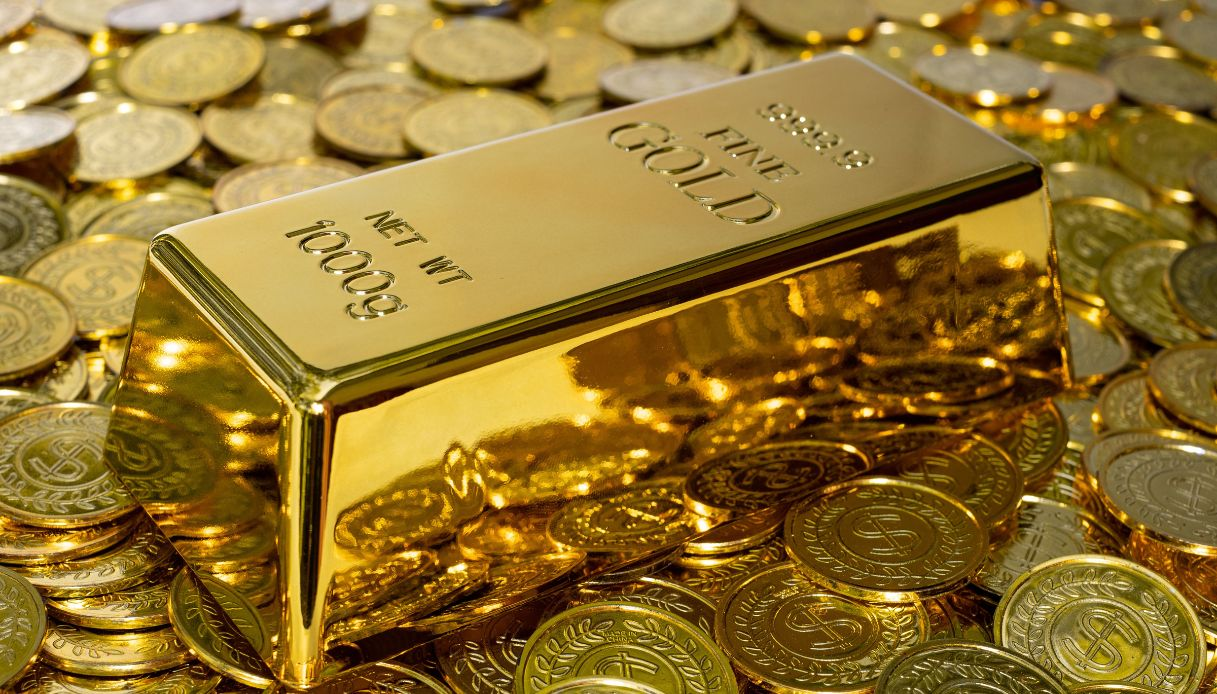

In [1]:
from IPython.display import display, Image
display(Image(filename="oro.jpg"))

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

db=pd.read_csv("oro.csv")
print(db.isnull().sum()/len(db))
print(db.head())

Date             0.0
Open             0.0
High             0.0
Low              0.0
Close            0.0
                ... 
USO_High         0.0
USO_Low          0.0
USO_Close        0.0
USO_Adj Close    0.0
USO_Volume       0.0
Length: 81, dtype: float64
         Date        Open        High         Low       Close   Adj Close  \
0  2011-12-15  154.740005  154.949997  151.710007  152.330002  152.330002   
1  2011-12-16  154.309998  155.369995  153.899994  155.229996  155.229996   
2  2011-12-19  155.479996  155.860001  154.360001  154.869995  154.869995   
3  2011-12-20  156.820007  157.429993  156.580002  156.979996  156.979996   
4  2011-12-21  156.979996  157.529999  156.130005  157.160004  157.160004   

     Volume     SP_open     SP_high      SP_low  ...    GDX_Low  GDX_Close  \
0  21521900  123.029999  123.199997  121.989998  ...  51.570000  51.680000   
1  18124300  122.230003  122.949997  121.300003  ...  52.040001  52.680000   
2  12547200  122.059998  122.320000  120.0299

Cleaning and Scaling Data

In [3]:


from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
db1=db.copy()
scaler=StandardScaler()
db1["Date"]=pd.to_datetime(db1["Date"])

db1.insert(1,"adjclose",db1["Adj Close"])
db1.iloc[:,2:]=scaler.fit_transform(db1.iloc[:,2:])
del db1["Adj Close"]
scalergold=StandardScaler()
db1["adjclose"]=scalergold.fit_transform(db1[["adjclose"]])

db2=db1.iloc[:,:7].copy()
print(db2.head())

        Date  adjclose      Open      High       Low     Close    Volume
0 2011-12-15  1.426632  1.564704  1.537256  1.433596  1.426632  2.658016
1 2011-12-16  1.592051  1.540163  1.561084  1.559519  1.592051  1.967348
2 2011-12-19  1.571516  1.606936  1.588884  1.585969  1.571516  0.833630
3 2011-12-20  1.691874  1.683413  1.677956  1.713618  1.691874  0.140258
4 2011-12-21  1.702141  1.692543  1.683630  1.687744  1.702141  0.721601


In [4]:
db.insert(1,"volume",db["Volume"])
db3=db.iloc[:,:6].copy()
scalermodel1=StandardScaler()
db3[["volume","Open","High","Low"]]=scalermodel1.fit_transform(db3[["volume","Open","High","Low"]])
scalerclose=StandardScaler()
db3["Close"]=scalerclose.fit_transform(db3[["Close"]])
db3["Date"]=pd.to_datetime(db3["Date"])
print(db3.dtypes)

Date      datetime64[ns]
volume           float64
Open             float64
High             float64
Low              float64
Close            float64
dtype: object


In [5]:
cor=db.iloc[:,1:].corr().stack().reset_index()
cor.columns=["var1","var2","cor"]
cor=cor.query("var1=='Close' and var2!='Close' and cor<-0.7")
print(cor)

      var1        var2       cor
387  Close  USDI_Price -0.721569
388  Close   USDI_Open -0.720140
389  Close   USDI_High -0.720023
390  Close    USDI_Low -0.722078


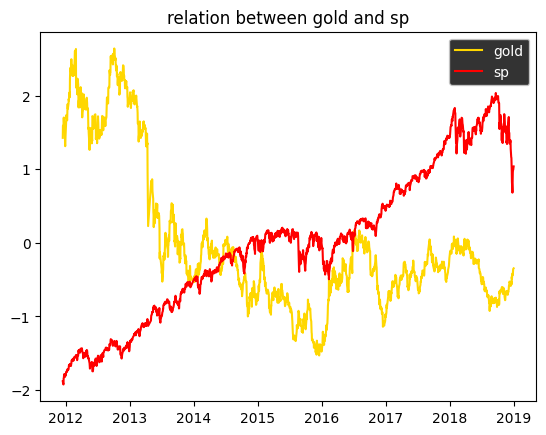

In [6]:
plt.plot(db1["Date"],db1["Close"],color="gold")
plt.plot(db1["Date"],db1["SP_close"],color="red")
plt.style.use("dark_background")
plt.title("relation between gold and sp")
plt.legend(["gold","sp"])

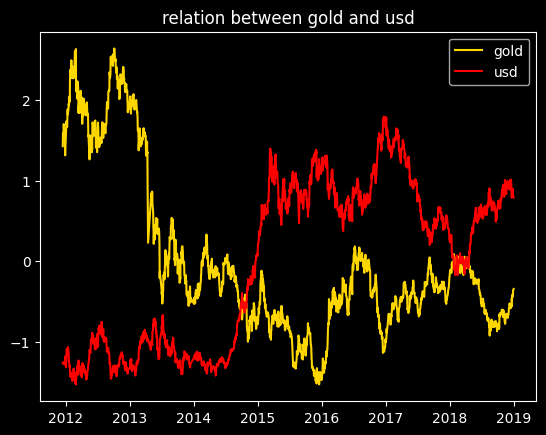

In [7]:
plt.plot(db1["Date"],db1["Close"],color="gold")
plt.plot(db1["Date"],db1["USDI_Price"],color="red")
plt.title("relation between gold and usd")
plt.legend(["gold","usd"])

0.8818328940504291
        Date  adjclose      Open      High       Low     Close    Volume  \
0 2011-12-15  1.426632  1.564704  1.537256  1.433596  1.426632  2.658016   
1 2011-12-16  1.592051  1.540163  1.561084  1.559519  1.592051  1.967348   
2 2011-12-19  1.571516  1.606936  1.588884  1.585969  1.571516  0.833630   
3 2011-12-20  1.691874  1.683413  1.677956  1.713618  1.691874  0.140258   
4 2011-12-21  1.702141  1.692543  1.683630  1.687744  1.702141  0.721601   

   tomorrow  Close_Next_Day  
0         1        1.592051  
1         0        1.571516  
2         1        1.691874  
3         1        1.702141  
4         0        1.638255  
        volume      Open      High       Low     Close
0     2.658016  1.564704  1.537256  1.433596  1.426632
1     1.967348  1.540163  1.561084  1.559519  1.592051
2     0.833630  1.606936  1.588884  1.585969  1.571516
3     0.140258  1.683413  1.677956  1.713618  1.691874
4     0.721601  1.692543  1.683630  1.687744  1.702141
...        ...

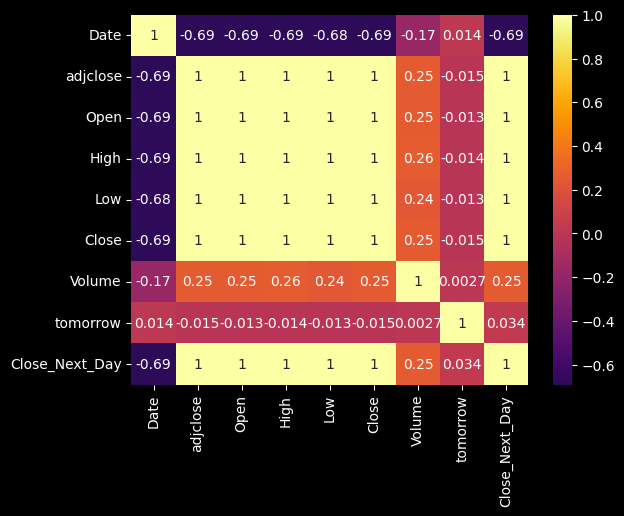

In [23]:
#Choosing the model

# db2=db2.drop(columns=["adjclose"])
db2['Close_Next_Day'] = db2['Close'].shift(-1)
# db2.insert(7,"tomorrow", [0 if x > y else 1 for x,y in zip(db2["Close"],db2["Close_Next_Day"])])
# print(db2.copy())
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import seaborn as sns
from sklearn.metrics import r2_score,accuracy_score
db2=db2.iloc[:-1,:]
cor2=db2.corr()
sns.heatmap(cor2,annot=True, cmap="inferno", center=0)
x=db2.drop(columns=["Date","Close_Next_Day","tomorrow","adjclose"])
x.insert(0,"volume",x["Volume"])
x=x.drop(columns=["Volume"])
# x=db2["Volume"].reset_index()
y=db2["Close_Next_Day"]
model=LogisticRegression()
model2=GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,random_state=42)
model3=RandomForestClassifier(n_estimators=200,random_state=42)
model4=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,random_state=42)
result=cross_validate(model4,x,y,cv=10)
print(result["test_score"].mean())
print(db2.head())
print(x)





Text(0.5, 1.0, 'volume increase when price is increasing')

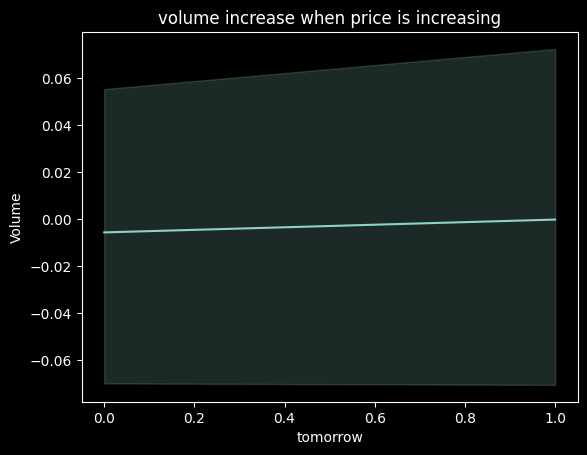

In [24]:
sns.lineplot(x="tomorrow", y="Volume",data=db2)
plt.title("volume increase when price is increasing")

In [25]:
#Building the model

xtrain,xtest,ytrain,ytest=train_test_split(x,y,train_size=0.7,random_state=0)
model4.fit(xtrain,ytrain)
pred=model4.predict(xtest)
print(x)
print(y)

print(r2_score(ytest,pred))

        volume      Open      High       Low     Close
0     2.658016  1.564704  1.537256  1.433596  1.426632
1     1.967348  1.540163  1.561084  1.559519  1.592051
2     0.833630  1.606936  1.588884  1.585969  1.571516
3     0.140258  1.683413  1.677956  1.713618  1.691874
4     0.721601  1.692543  1.683630  1.687744  1.702141
...        ...       ...       ...       ...       ...
1706 -0.877061 -0.558355 -0.580631 -0.547263 -0.558405
1707 -0.192025 -0.610290 -0.598786 -0.586362 -0.585214
1708  0.001743 -0.568057 -0.557370 -0.542088 -0.539010
1709 -0.183650 -0.540663 -0.547725 -0.515638 -0.523039
1710  1.093890 -0.518405 -0.504607 -0.539213 -0.564109

[1711 rows x 5 columns]
0       1.592051
1       1.571516
2       1.691874
3       1.702141
4       1.638255
          ...   
1706   -0.585214
1707   -0.539010
1708   -0.523039
1709   -0.564109
1710   -0.460864
Name: Close_Next_Day, Length: 1711, dtype: float64
0.9932467153714626


In [26]:
new=pd.DataFrame({"volume":[9136300],
                "Open":[156.820007],
                "High":[157.429993],
                "Low":[156.580002],
                "Close":[156.979996]})
new[["volume","Open","High","Low"]]=scalermodel1.transform(new[["volume","Open","High","Low"]])
new["Close"]=scalerclose.transform(new[["Close"]])
newpred=model4.predict(new)
print(newpred)
prediction=pd.DataFrame({"ris":[newpred]})
prediction["ris"]=scalerclose.inverse_transform(prediction[["ris"]])
print(prediction)
print(db.head())

[1.69831122]
          ris
0  157.092856
         Date    volume        Open        High         Low       Close  \
0  2011-12-15  21521900  154.740005  154.949997  151.710007  152.330002   
1  2011-12-16  18124300  154.309998  155.369995  153.899994  155.229996   
2  2011-12-19  12547200  155.479996  155.860001  154.360001  154.869995   
3  2011-12-20   9136300  156.820007  157.429993  156.580002  156.979996   
4  2011-12-21  11996100  156.979996  157.529999  156.130005  157.160004   

    Adj Close    Volume     SP_open     SP_high  ...    GDX_Low  GDX_Close  \
0  152.330002  21521900  123.029999  123.199997  ...  51.570000  51.680000   
1  155.229996  18124300  122.230003  122.949997  ...  52.040001  52.680000   
2  154.869995  12547200  122.059998  122.320000  ...  51.029999  51.169998   
3  156.979996   9136300  122.180000  124.139999  ...  52.369999  52.990002   
4  157.160004  11996100  123.930000  124.360001  ...  52.419998  52.959999   

   GDX_Adj Close  GDX_Volume   USO_Open

In [27]:
from sklearn.inspection import permutation_importance
score=permutation_importance(model4,xtest,ytest,scoring="r2", n_repeats=100)
scoring=pd.DataFrame({"feature":x.columns, "scoring":score.importances_mean})
print(scoring)

  feature   scoring
0  volume -0.000655
1    Open  0.018119
2    High  0.122609
3     Low  0.034863
4   Close  0.578596
